# Using the attribution runs to look at tropical Atlantic variability

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def load_cvdp_timeseries(ts_name,dir_name):
    nc_file_name=ts_name+"."+dir_name+".nc"
    if os.path.exists(nc_file_name):
        # Load the dataset using xarray
        da = xr.open_dataset(nc_file_name)
        print('Loaded '+ts_name+' from pre-existing file called '+nc_file_name)
    else:
        print('Extracting '+ts_name+' from all the cvdp_files in '+dir_name+' ...')
        # Look in the provided directory
        file_names = os.listdir(dir_name)
        # Filter the file names to include only those with the .nc extension
        paths = [file_name for file_name in file_names if file_name.endswith('.nc')]
        #Load in an example file to get some metadata
        dataset = xr.open_dataset(dir_name+'/'+paths[0],decode_times=False)
        dims=dataset.dims
        dataset.time.attrs['calendar']='360_day'
        dataset.time_mon1.attrs['calendar']='360_day'
        dataset.time_mon2.attrs['calendar']='360_day'
        dataset.time_mon3.attrs['calendar']='360_day'
        if "time_lag_cor" in dims:
            dataset.time_lag_cor.attrs['calendar']='360_day'

        dataset=xr.decode_cf(dataset,decode_times=True)
        dataset=dataset.convert_calendar('proleptic_gregorian',align_on='year')
        time=dataset.time
        num_months = time.size #number of months (this code assumes all files have equal length!)
        # Number of ensemble members
        num_ensemble_members = len(paths)
        # Create a DataArray to hold all the ensemble members
        ensemble_member = xr.IndexVariable('ensemble_member', np.arange(num_ensemble_members))
        da = xr.DataArray(np.full((num_ensemble_members,num_months),np.nan), coords=[ensemble_member,time],
                          dims=['ensemble_member', 'time'], name=ts_name)
        # Fill up the dataArray by looping over each file
        for i in range(1,num_ensemble_members-1):
            # Open the dataset using xarray
            dataset = xr.open_dataset(dir_name+'/'+paths[i],decode_times=False)
            dataset.time.attrs['calendar']='360_day'
            dataset.time_mon1.attrs['calendar']='360_day'
            dataset.time_mon2.attrs['calendar']='360_day'
            dataset.time_mon3.attrs['calendar']='360_day'
            if "time_lag_cor" in dataset.dims:
                dataset.time_lag_cor.attrs['calendar']='360_day'
            dataset=xr.decode_cf(dataset,decode_times=True)
            dataset=dataset.convert_calendar('proleptic_gregorian',align_on='year')
            # Extract time series of interest
            da[i,:] = dataset[ts_name]

        # Print the information about the DataArray
        print('and saved it to a file called '+nc_file_name+'for later use')
        da.to_netcdf(nc_file_name)
    
    return da

In [3]:
aer_array=load_cvdp_timeseries('atlantic_nino','cmip6.hist-aer.cvdp_data')
ghg_array=load_cvdp_timeseries('atlantic_nino','cmip6.hist-GHG.cvdp_data')
nat_array=load_cvdp_timeseries('atlantic_nino','cmip6.hist-nat.cvdp_data')
all_array=load_cvdp_timeseries('atlantic_nino','cmip6.hist.cvdp_data')
all_array


Loaded atlantic_nino from pre-existing file called atlantic_nino.cmip6.hist-aer.cvdp_data.nc
Loaded atlantic_nino from pre-existing file called atlantic_nino.cmip6.hist-GHG.cvdp_data.nc
Loaded atlantic_nino from pre-existing file called atlantic_nino.cmip6.hist-nat.cvdp_data.nc
Loaded atlantic_nino from pre-existing file called atlantic_nino.cmip6.hist.cvdp_data.nc


<xarray.Dataset>
Dimensions:          (ensemble_member: 102, time: 1140)
Coordinates:
  * ensemble_member  (ensemble_member) int64 0 1 2 3 4 5 ... 96 97 98 99 100 101
  * time             (time) datetime64[ns] 1920-01-15 1920-02-15 ... 2014-12-16
Data variables:
    atlantic_nino    (ensemble_member, time) float64 ...

Text(0.5, 1.0, 'ATL3 in natural only runs (oC)')

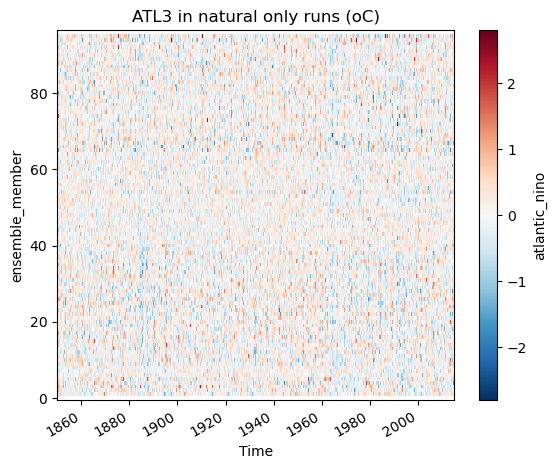

In [4]:
# convert to anomalies
nat_array['atlantic_nino'].plot()
plt.title('ATL3 in natural only runs (oC)')

/home/ucfaccb/miniconda3/envs/my-cli-py/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'Aerosol-driven change in ATL3 std dev. (since 1850-99, oC^2)')

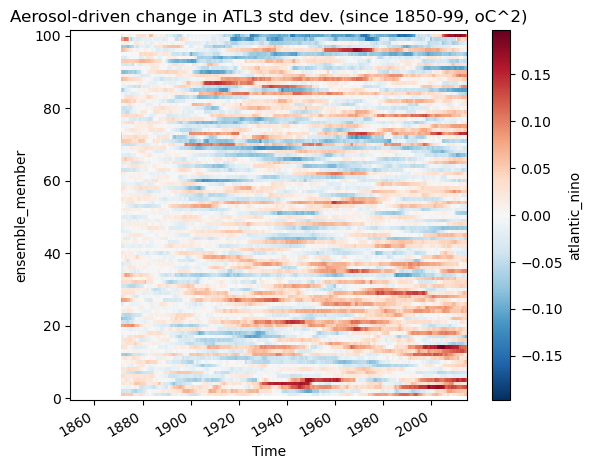

In [5]:
# Compute the running standard deviation
window_size = 252  # Number of months in the running window
running_std = aer_array['atlantic_nino'].rolling(time=window_size).std()
# convert to anomalies
running_std=running_std-running_std.sel(time=slice('1850-01-01','1899-12-31')).mean(dim='time')
running_std.plot()
plt.title('Aerosol-driven change in ATL3 std dev. (since 1850-99, oC^2)')

Text(0.5, 1.0, 'ATL3 in GHG-driven runs (oC)')

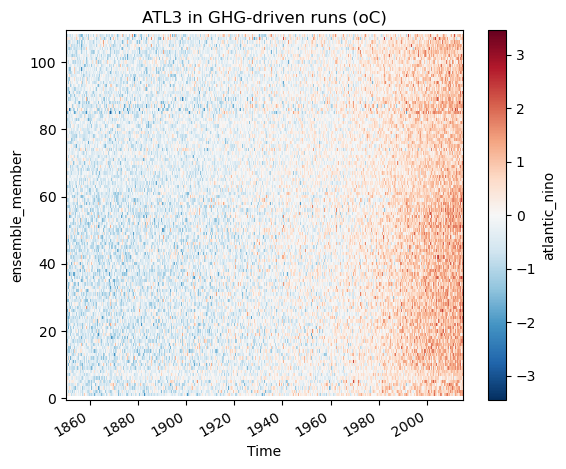

In [6]:
#Create some plots
#mean_state=ghg_array-ghg_array.sel(time=slice('1850-01-01','1899-12-31')).mean(dim='time')
mean_state=ghg_array['atlantic_nino']
mean_state.plot()
plt.title('ATL3 in GHG-driven runs (oC)')

/home/ucfaccb/miniconda3/envs/my-cli-py/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'GHG-driven change in ATL3 std dev. (since 1850-99, oC^2)')

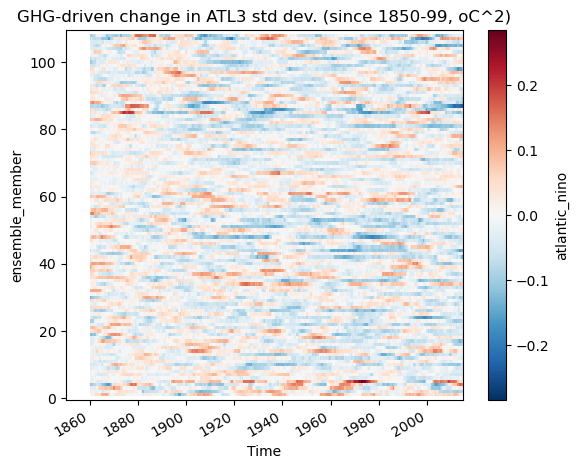

In [7]:
# Compute the running standard deviation
window_size = 120  # Number of months in the running window
running_std = ghg_array['atlantic_nino'].rolling(time=window_size).std()
# convert to anomalies
running_std=running_std-running_std.sel(time=slice('1850-01-01','1899-12-31')).mean(dim='time')
running_std.plot()
plt.title('GHG-driven change in ATL3 std dev. (since 1850-99, oC^2)')

#### Now create a more conventional time series figure. Basing this on IPCC AR6 WG1 Fig 3.9 

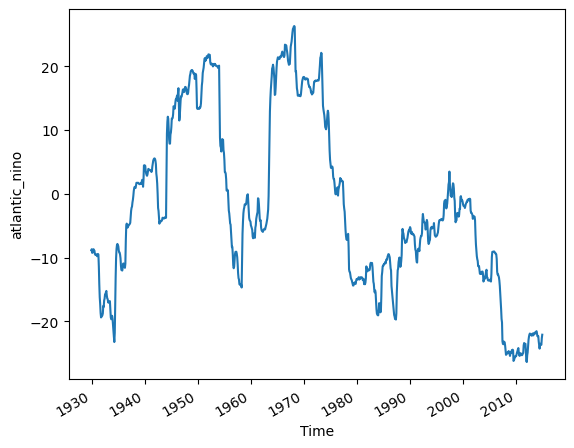

In [8]:
# Load in some obnservations...
obs = xr.open_dataset('atlantic_nino.ERSST_v5.cvdp_data.1920-2014.nc',decode_times=False)
obs.time.attrs['calendar']='360_day'
obs=xr.decode_cf(obs,decode_times=True)
obs=obs.convert_calendar('proleptic_gregorian',align_on='year')
obs_smoothed_normed=obs.atlantic_nino.rolling(time=window_size).mean()-obs.atlantic_nino.sel(time=slice('1920-01-01','1949-12-31')).mean(dim='time')
obs_std=obs.atlantic_nino.rolling(time=window_size).std()
obs_std=100*(obs.atlantic_nino.rolling(time=window_size).std()-obs_std.sel(time=slice('1920-01-01','1949-12-31')).mean())/obs_std.sel(time=slice('1920-01-01','1949-12-31')).mean()
obs_std.plot()



<xarray.Dataset>
Dimensions:          (ensemble_member: 102, time: 1980)
Coordinates:
  * ensemble_member  (ensemble_member) int64 0 1 2 3 4 5 ... 96 97 98 99 100 101
  * time             (time) datetime64[ns] 1850-01-15 1850-02-15 ... 2014-12-16
Data variables:
    atlantic_nino    (ensemble_member, time) float64 nan nan nan ... nan nan nan


/home/ucfaccb/miniconda3/envs/my-cli-py/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/ucfaccb/miniconda3/envs/my-cli-py/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/ucfaccb/miniconda3/envs/my-cli-py/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/ucfaccb/miniconda3/envs/my-cli-py/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/ucfaccb/miniconda3/envs/my-cli-py/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1

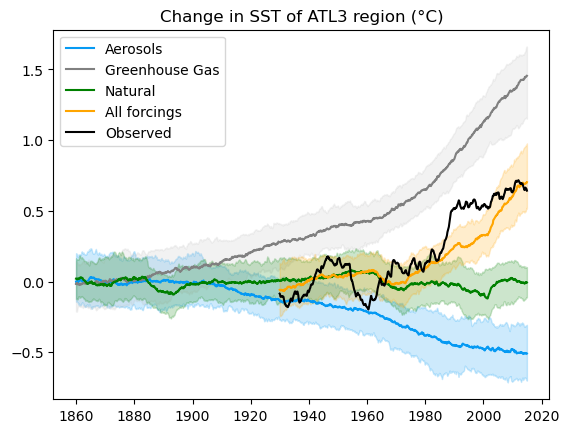

In [9]:
# Compute the median and percentile ranges along the y-axis
print(aer_array)
median_raw = aer_array['atlantic_nino'].rolling(time=window_size).mean().median(dim='ensemble_member')
median = median_raw-median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time')
bot_pctile_raw = aer_array['atlantic_nino'].rolling(time=window_size).mean().quantile(0.05, dim='ensemble_member')
bot_pctile = bot_pctile_raw-median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time')
top_pctile_raw = aer_array['atlantic_nino'].rolling(time=window_size).mean().quantile(0.95, dim='ensemble_member')
top_pctile = top_pctile_raw-median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time')
# Plot the results
plt.plot(aer_array.time, median, label='Aerosols',color='xkcd:azure')
plt.fill_between(aer_array.time, bot_pctile, top_pctile, alpha=0.2,color='xkcd:azure')

#repeat for the GHG runs
median_raw = ghg_array['atlantic_nino'].rolling(time=window_size).mean().median(dim='ensemble_member')
median = median_raw-median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time')
bot_pctile_raw = ghg_array['atlantic_nino'].rolling(time=window_size).mean().quantile(0.05, dim='ensemble_member')
bot_pctile = bot_pctile_raw-median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time')
top_pctile_raw = ghg_array['atlantic_nino'].rolling(time=window_size).mean().quantile(0.95, dim='ensemble_member')
top_pctile = top_pctile_raw-median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time')
plt.plot(ghg_array.time, median, label='Greenhouse Gas',color='gray')
plt.fill_between(ghg_array.time, bot_pctile, top_pctile, alpha=0.2,color='silver')

#repeat for the natural runs
median_raw = nat_array['atlantic_nino'].rolling(time=window_size).mean().median(dim='ensemble_member')
median = median_raw-median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time')
bot_pctile_raw = nat_array['atlantic_nino'].rolling(time=window_size).mean().quantile(0.05, dim='ensemble_member')
bot_pctile = bot_pctile_raw-median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time')
top_pctile_raw = nat_array['atlantic_nino'].rolling(time=window_size).mean().quantile(0.95, dim='ensemble_member')
top_pctile = top_pctile_raw-median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time')
plt.plot(nat_array.time, median, label='Natural',color='green')
plt.fill_between(nat_array.time, bot_pctile, top_pctile, alpha=0.2,color='green')

#repeat for the all forcing runs
median_raw = all_array['atlantic_nino'].rolling(time=window_size).mean().median(dim='ensemble_member')
median = median_raw-median_raw.sel(time=slice('1920-01-01','1949-12-31')).mean(dim='time')
bot_pctile_raw = all_array['atlantic_nino'].rolling(time=window_size).mean().quantile(0.05, dim='ensemble_member')
bot_pctile = bot_pctile_raw-median_raw.sel(time=slice('1920-01-01','1949-12-31')).mean(dim='time')
top_pctile_raw = all_array['atlantic_nino'].rolling(time=window_size).mean().quantile(0.95, dim='ensemble_member')
top_pctile = top_pctile_raw-median_raw.sel(time=slice('1920-01-01','1949-12-31')).mean(dim='time')
plt.plot(all_array.time, median, label='All forcings',color='orange')
plt.fill_between(all_array.time, bot_pctile, top_pctile, alpha=0.2,color='orange')

# Add in the observations...
plt.plot(obs.time,obs_smoothed_normed, label='Observed',color='black')

# Customize the plot
plt.title('Change in SST of ATL3 region (\u00b0C)')
plt.legend()

# Show the plot
plt.show()

<xarray.Dataset>
Dimensions:          (ensemble_member: 102, time: 1980)
Coordinates:
  * ensemble_member  (ensemble_member) int64 0 1 2 3 4 5 ... 96 97 98 99 100 101
  * time             (time) datetime64[ns] 1850-01-15 1850-02-15 ... 2014-12-16
Data variables:
    atlantic_nino    (ensemble_member, time) float64 nan nan nan ... nan nan nan


/home/ucfaccb/miniconda3/envs/my-cli-py/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ucfaccb/miniconda3/envs/my-cli-py/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ucfaccb/miniconda3/envs/my-cli-py/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/ucfaccb/miniconda3/envs/my-cli-py/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ucfaccb/miniconda3/envs/my-cli-py/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = n

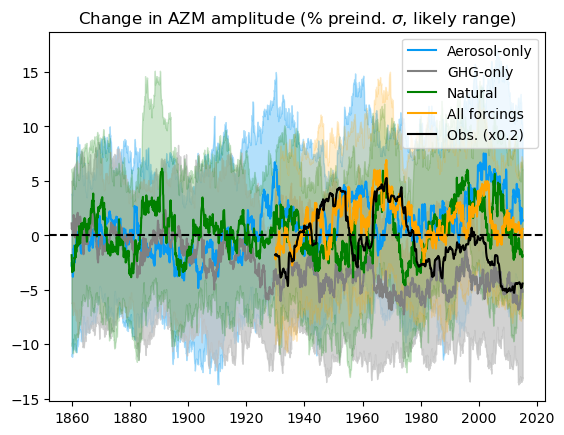

In [13]:
# Compute the median and percentile ranges along the y-axis
print(aer_array)
median_raw = aer_array['atlantic_nino'].rolling(time=window_size).std().median(dim='ensemble_member')
median = 100*(median_raw-median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time'))/median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time')
bot_pctile_raw = aer_array['atlantic_nino'].rolling(time=window_size).std().quantile(0.33, dim='ensemble_member')
bot_pctile = 100*(bot_pctile_raw-median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time'))/median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time')
top_pctile_raw = aer_array['atlantic_nino'].rolling(time=window_size).std().quantile(0.66, dim='ensemble_member')
top_pctile = 100*(top_pctile_raw-median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time'))/median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time')
# Plot the results
plt.plot(aer_array.time, median, label='Aerosol-only',color='xkcd:azure')
plt.fill_between(aer_array.time, bot_pctile, top_pctile, alpha=0.3,color='xkcd:azure')

#repeat for the GHG runs
median_raw = ghg_array['atlantic_nino'].rolling(time=window_size).std().median(dim='ensemble_member')
median = 100*(median_raw-median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time'))/median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time')
bot_pctile_raw = ghg_array['atlantic_nino'].rolling(time=window_size).std().quantile(0.33, dim='ensemble_member')
bot_pctile = 100*(bot_pctile_raw-median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time'))/median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time')
top_pctile_raw = ghg_array['atlantic_nino'].rolling(time=window_size).std().quantile(0.66, dim='ensemble_member')
top_pctile = 100*(top_pctile_raw-median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time'))/median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time')
plt.plot(ghg_array.time, median, label='GHG-only',color='gray')
plt.fill_between(ghg_array.time, bot_pctile, top_pctile, alpha=0.7,color='silver')


#repeat for the natural runs
median_raw = nat_array['atlantic_nino'].rolling(time=window_size).std().median(dim='ensemble_member')
median = 100*(median_raw-median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time'))/median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time')
bot_pctile_raw = nat_array['atlantic_nino'].rolling(time=window_size).std().quantile(0.33, dim='ensemble_member')
bot_pctile = 100*(bot_pctile_raw-median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time'))/median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time')
top_pctile_raw = nat_array['atlantic_nino'].rolling(time=window_size).std().quantile(0.66, dim='ensemble_member')
top_pctile = 100*(top_pctile_raw-median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time'))/median_raw.sel(time=slice('1850-01-01','1879-12-31')).mean(dim='time')
plt.plot(nat_array.time, median, label='Natural',color='green')
plt.fill_between(nat_array.time, bot_pctile, top_pctile, alpha=0.2,color='green')

#repeat for the all forcing runs
median_raw = all_array['atlantic_nino'].rolling(time=window_size).std().median(dim='ensemble_member')
median = 100*(median_raw-median_raw.sel(time=slice('1920-01-01','1949-12-31')).mean(dim='time'))/median_raw.sel(time=slice('1920-01-01','1949-12-31')).mean(dim='time')
bot_pctile_raw = all_array['atlantic_nino'].rolling(time=window_size).std().quantile(0.33, dim='ensemble_member')
bot_pctile = 100*(bot_pctile_raw-median_raw.sel(time=slice('1920-01-01','1949-12-31')).mean(dim='time'))/median_raw.sel(time=slice('1920-01-01','1949-12-31')).mean(dim='time')
top_pctile_raw = all_array['atlantic_nino'].rolling(time=window_size).std().quantile(0.66, dim='ensemble_member')
top_pctile = 100*(top_pctile_raw-median_raw.sel(time=slice('1920-01-01','1949-12-31')).mean(dim='time'))/median_raw.sel(time=slice('1920-01-01','1949-12-31')).mean(dim='time')
plt.plot(all_array.time, median, label='All forcings',color='orange')
plt.fill_between(all_array.time, bot_pctile, top_pctile, alpha=0.2,color='orange')


# Add in the observations...
plt.plot(obs.time,obs_std/5, label='Obs. (x0.2)',color='black')

# Customize the plot
plt.title(r'Change in AZM amplitude (% preind. $\sigma$, likely range)')
plt.axhline(y=0.0,color='black',linestyle='--')
plt.legend()

# Show the plot
plt.show()